# Quickstart: Live Data via yfinance

This notebook is a light, end-to-end example using the automated yfinance
connector. It is intentionally shorter than the CSV demos.

If you want a full method tour, see:
- `examples/aapl_volcurve_probcurve_demo.ipynb`
- `examples/aapl_volsurface_probsurface_demo.ipynb`

<b> We will demonstrate the simplest way to quickly find the future implied probability distribution of a ticker, like Palantir. </b>

This demo consists of 2 sections:
1. Compute the probability distribution of an asset on a specific future date.
2. Compute the future probability over time.

---

## 1. Compute the probability distribution of an asset on a specific future date (using the `ProbCurve` object)

In [2]:
import matplotlib.pyplot as plt

from oipd import MarketInputs, sources, ProbCurve, ProbSurface

### 1.1. I'll show how to use the convenient `sources` object to query and download data.

First, we use the `sources` object to query and download data from yfinance

In [3]:
ticker = "PLTR" # select a ticker

# List available expiries
expiries = sources.list_expiry_dates(ticker) # vendor defaults to "yfinance". Only yfinance is available for now, but we may support other vendors in the future like Alpaca, IBKR, etc.
expiries[:5]

['2026-02-06', '2026-02-13', '2026-02-20', '2026-02-27', '2026-03-06']

Use `sources.fetch_chain()` to download

In [ ]:
# Use the first expiry for a single-expiry VolCurve
single_expiry = expiries[5]
chain, snapshot = sources.fetch_chain(ticker, expiries=single_expiry) # this downloads the options chain data, as well as a snapshot of the market conditions at the time you downloaded the data (e.g. stock price, download time, etc.)

print(snapshot.underlying_price) # currently Palantir is $130.01
print(single_expiry) # Mar 13, 2026

130.01
2026-03-13


`MarketInputs` is a snapshot of market conditions (valuation date, underlying price, risk free rate) that the model uses.

In [16]:
market = MarketInputs(
    valuation_date=snapshot.date,               # use the snapshot to fill the date and price (this demo is being created on Feb 4, 2026)
    underlying_price=snapshot.underlying_price, # use the snapshot to fill the date and price
    risk_free_rate=0.04,                        # the risk-free rate of return. Use the US Fed or Treasury yields that are closest to the horizon of the expiries (e.g. overnight since we're evaluating 2-days ahead)
)

### 1.2. Generate the implied-probability distribution using the `ProbCurve` object

Now that all input data is loaded and defined, we can generate the probability. The probability curve is the risk-neutral distribution implied by the market. You can query tail probabilities, quantiles, and moments.

The simplest way to do this is using the `ProbCurve.from_chain()` constructor.

In [17]:
prob = ProbCurve.from_chain(chain, market) # --> returns a `ProbCurve` object. This is a container that holds information about market-implied probabilities. 

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/interface/volatility.py:189: UserWarning: Filled 31 missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(


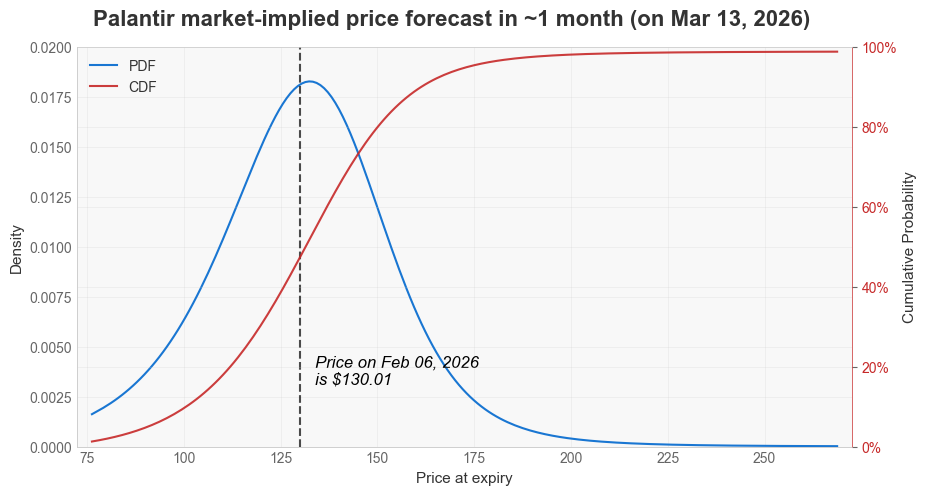

In [21]:
prob.plot(title="Palantir market-implied price forecast in ~1 month (on Mar 13, 2026)")
plt.show()

Now, we can query the result to quantify probabilities and other statistics.

In [8]:
spot = market.underlying_price
print(spot) # $130.01


prob_below = prob.prob_below(100) # calculates Prob(price at expiry < 100)
prob_above = prob.prob_above(150) # calculates Prob(price at expiry >= 150)
prob_between = prob.prob_between(100, 150)

quantiles = {
    "q10": prob.quantile(0.10),
    "q50": prob.quantile(0.50),
    "q90": prob.quantile(0.90),
}

moments = {
    "mean": prob.mean(),
    "variance": prob.variance(),
    "skew": prob.skew(),
    "kurtosis": prob.kurtosis(),
}

{
    "prob_below": prob_below,
    "prob_above": prob_above,
    "prob_between": prob_between,
    **quantiles,
    **moments,
}

130.01


{'prob_below': 0.031921027243170697,
 'prob_above': 0.05834090989994978,
 'prob_between': 0.9097380628568795,
 'q10': 112.50282221958152,
 'q50': 131.26689614971605,
 'q90': 146.22218203775492,
 'mean': 130.104262099567,
 'variance': 212.70568902827983,
 'skew': -0.04098840058545823,
 'kurtosis': 4.2631440115938455}

---

## 2. Compute the future probability over time (using the `ProbSurface` object)

### 2.1. I'll show how to use the convenient `sources` object to query and download data.

First, we use the `sources` object to query and download data from yfinance

In [9]:
ticker = "PLTR" # select a ticker

# we will download all data for the next 3 months
chain_surface, snapshot_surface = sources.fetch_chain(ticker, horizon='3m')

`MarketInputs` is a snapshot of market conditions (valuation date, underlying price, risk free rate) that the model uses.

In [10]:
surface_market = MarketInputs(
    valuation_date=snapshot_surface.date,
    risk_free_rate=0.04,
    underlying_price=snapshot_surface.underlying_price,
)

### 2.2. Generate the implied-probability over time using the `ProbSurface` object

Now that all input data is loaded and defined, we can generate the probability. The probability curve is the risk-neutral distribution implied by the market. You can query tail probabilities, quantiles, and moments.

The simplest way to do this is using the `ProbSurface.from_chain()` method.

<br>

<i> Note the naming convention. Earlier, we used the `ProbCurve` as we were computing a 2d slice for a single date. Now that we are computing probability over time, we are creating a 3d 'surface', so we use `ProbSurface` </i>

In [11]:
surface = ProbSurface.from_chain(chain_surface, surface_market)

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/pipelines/vol_surface/svi_slices.py:112: UserWarning: Filled missing mid prices with last_price for 7 expiries: [2026-02-13, 2026-02-20, 2026-02-27 ... 2026-04-17]
  warnings.warn(
/Users/henrytian/Coding Projects/Github/probabilistic/oipd/pipelines/vol_surface/svi_slices.py:150: UserWarning: Filtered 24 stale option rows across 6 expiries: [2026-02-13, 2026-02-20, 2026-02-27 ... 2026-04-17] (most recent: 4 days, oldest: 24 days) older than 3 days.
  warnings.warn(


Plot the probability distribution over time as a fan-chart. Looks like the market expects Gamestop to decline in price.

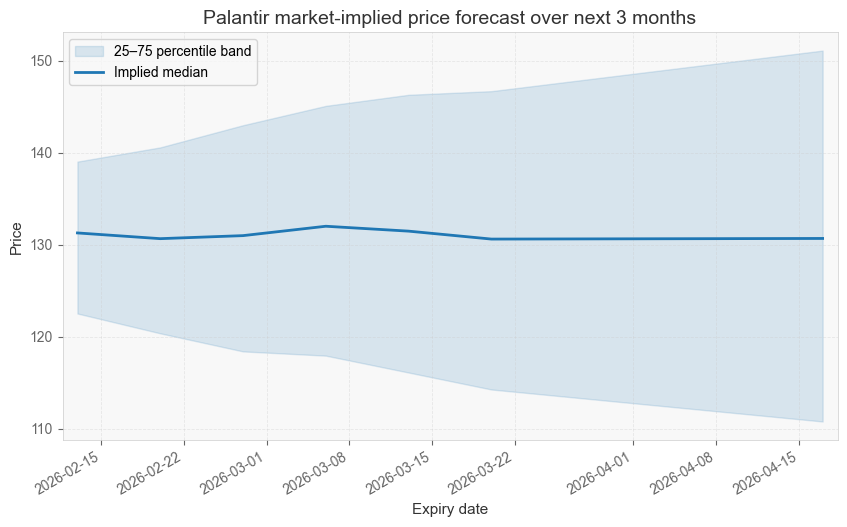

In [14]:
surface.plot_fan(title="Palantir market-implied price forecast over next 3 months")
plt.show()

## Next steps

If you want a deeper tour of all methods (Greeks, quantiles, slicing, and
interpolation), use the AAPL CSV notebooks in `examples/`.